<a href="https://colab.research.google.com/github/RachmaAyudyaw/MachineLearningDicodingGoogleResearchCollab/blob/main/ProyekAkhir_ImageClassificationModelDeployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!wget --no-check-certificate \
https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-07-23 15:17:59--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  7.64MB/s    in 43s     

2021-07-23 15:18:42 (7.21 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [ ]:
import zipfile,os
local_zip='/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir='/tmp/rockpaperscissors/'
train_dir=os.path.join(base_dir,'rps-cv-images')

In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)

In [ ]:
train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=4,
    class_mode='categorical',
    subset='training'
)

validation_generator=test_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=4,
    class_mode='categorical',
    subset='validation'
)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2
model = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  
])
model.layers[0].trainable = False

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92):
      print("\nAkurasi telah mencapai > 92%!")
      self.model.stop_training=True
callbacks=myCallback()

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history=model.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=50,
                  verbose=2,
                  callbacks=[callbacks])

Epoch 1/50
438/438 - 31s - loss: 1.0827 - accuracy: 0.9166 - val_loss: 0.4375 - val_accuracy: 0.9474
Epoch 2/50
438/438 - 23s - loss: 0.3542 - accuracy: 0.9612 - val_loss: 0.1948 - val_accuracy: 0.9703

Akurasi telah mencapai > 92%!


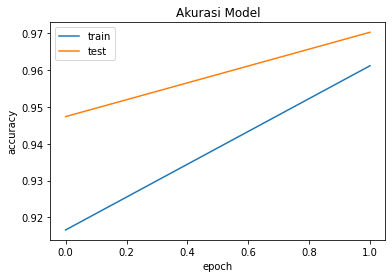

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

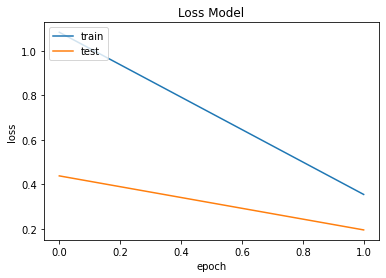

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Konversi Model ke TFLite
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpw8tj9xwq/assets


In [ ]:
with tf.io.gfile.GFile('model.tflite','wb') as f:
  f.write(tflite_model)